# Introduction to Membership Inference Attack
**Privacy testing for ML Models**

This intro will perform an MIA privacy analysis by running an experiment where a comparison of memorization rates vs models of various architectures, various sizes, or where the number of classes in the source training/validation datasets are changed.


## Experiment Results
Plots are generated showing:
* Training accuracy and loss, validation accuracy and loss vs epochs of training
* MIA results, using logistic regression & Threshold attack methods

The expected results should show:
1. Models overfit as the number of epochs increases
2. Different models, with different architectures and different capacities, overfit at different rates
3. Overfitting and model memorization measurements are covaried


## Experiment Design
In this truncated experiment we will compare different model architectures to eachother by running MIA assessments against them every E epochs.
E is a hyperparameter, set to every 3 epochs of training.

Experiment (Independent) variables include:
* model 'depth', or number of layers
* neurons per 'layer'
along with some other dimensions to tinker with.

The full experiment was not ported to this notebook, but can be viewed in [github[(https://github.com/morendav/mia_image_classifier) for anyone inclined to expand on this notebook for themselves.

Cheers!


### Credits

Dataset credit: kudos to TF public dataset CIFAR10

Source code and code liscence may be found on [github](http://github.com/morendav/mia_image_classifier)

# Step 1 - Setup the env

## 1.1 import python modules

Import libraries.


First import all the python modules that are needed, to do this run both of the following codeblocks

Note: tensorflow privacy will need to be installed if you are running this in colab.

In [1]:
!pip install tensorflow_privacy
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.4/359.4 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: mpmath
    Found existing installation: mpmath 1.3.0
    Uninstalling mpmath-1.3.0:
      Successfully uninstalled mpmath-1.3.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1

In [5]:
# Import standard & third party libraries
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import special
from pathlib import Path
from typing import Tuple, Union, Any


# Import tensorflow, tf datasetss, and tensorflow privacy libraries and utilities
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tf_datasets


In [6]:
# Install tensorflow privacy library & import some libraries
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackResultsCollection
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyMetric
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import PrivacyReportMetadata
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import SlicingSpec
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import privacy_report


# Set verbosity
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from sklearn.exceptions import ConvergenceWarning
# suppress convergence warnings for the logistic regression MIA
import warnings

warnings.simplefilter(action="ignore", category=ConvergenceWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)


## 1.2 Setup some helper methods

Define some helper methods & a class.


The first codeblock will create methods for building up ML models These methods accept a range of input parameters that may be used to configure additional experiments, including:

adjusting the number of neurons per laye
adjusting the depth (number of convolution2d layers or number of densely connected layers)
adjusting the activation funcction
In addition, these methods accept parameterized input shape, output number of prediction classes. These may be used if you want to change the dataset used for future experiments.

In [7]:
# Define MIA helper methods
# builder methods are used to create models with some arbitrary values for
# their characteristics (e.g. depth, number of convolutions, etc)
def conv_nn_builder(input_shape: Tuple[int],
                    num_classes: int,
                    depth: int,
                    neurons_per_layer: int = 64,
                    activation: str = 'relu'
                    ) -> tf.keras.models.Sequential:
    """
    Helper Method to build a multi-layered conv2d model of arbitrary depth (depth).
    The filter size for each conv2D is not parameterized. No padding per layer

    Args:
        input_shape: Integer tuple, shape of a sample image. e.g. (64,64,3)
        num_classes: Output, number of classes
        neurons_per_layer: number of neurons in each layer. Default 64 neurons
        depth: Depth of conv2D neural net
        activation: The activation function to use for conv and dense layers. Default RELU
    Returns:
        TF.Keras compiled model with the parameters passed to this nn builder method
    """
    model = Sequential()
    model.add(layers.Input(shape=input_shape))

    # loop to create some arbitrarily deep set of conv2d layers
    # depth is specified in the passed parameters for this builder method
    for _ in range(depth):
        model.add(layers.Conv2D(32, (3, 3), activation=activation))
        model.add(layers.MaxPooling2D())

    # flatten the conv2 layers in a single vector representation
    model.add(layers.Flatten())
    # apply a single layer of densely connected neurons_per_layer neurons, default 64 unless specified at method call
    model.add(layers.Dense(neurons_per_layer, activation=activation))
    model.add(layers.Dense(num_classes))  # logits must equal number of class in prediction space
    # compile the model using some plain
    model.compile(
        # Depending on the format of the labels numpy array (N:1, or 1:N) you will have to swap these definitions
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model


def dense_nn_builder(input_shape: Tuple[int],
                     num_classes: int,
                     depth: int,
                     neurons_per_layer: int = 64,
                     activation: str = 'relu'
                     ) -> tf.keras.models.Sequential:
    """
    Helper Method to build a multi-layered densely connected NN model of arbitrary depth (depth)


    Args:
        input_shape: Integer tuple, shape of a sample image. e.g. (64,64,3)
        num_classes: Output, number of classes
        neurons_per_layer: number of neurons in each layer. Default 64 neurons
        depth: Depth of densely connected neural networks
        activation: The activation function to use for conv and dense layers. Default RELU
    Returns:
        TF.Keras compiled model with the parameters passed to this nn builder method
    """
    model = Sequential()
    model.add(layers.Flatten(input_shape=input_shape))

    # loop to create hidden layers of model of arbitrary depth
    # each layer has neurons_per_layer neurons, which is default 64 unless specified at method call
    for _ in range(depth):
        model.add(layers.Dense(neurons_per_layer, activation=activation))
    model.add(layers.Dense(neurons_per_layer, activation=activation))  # conv2d has an additional hidden layer here
    # adding this (above) additional hidden layer to make this a fair comparison
    model.add(layers.Dense(num_classes))  # logits must equal number of class in prediction space
    model.compile(
        # Depending on the format of the labels numpy array (N:1, or 1:N) you will have to swap these definitions
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model



This next code block is used to create the dataset builder method.

As input, this dataset will accept a dataset (dictionary with at least keys 'image' and 'label' but can accept a dictionary of any length).

This method is used to lazy-truncate a larger dataset, that is pick N classes of an M class dataset where N < M. The classes are not chosen randomly, they are instead selected beginning at 0 and incrementally.

NOTE: assumes the source dataset is at least 10 classes.

In [8]:
def dataset_builder(dataset: dict,
                    num_classes: int = 10,
                    ):
    # ) -> tuple[Union[float, Any], Any, Any]:
    """
    Build a model-ready dataset for training and validation from an input dataset dictionary
    Assumes the dictionary passed is generated from TensorFlow datasets library,
    and has three keys: [image, label, id].

    Args:
        dataset: dict,
        num_classes: int = 10,
    Returns:
        ds_images images in dataset
        ds_labels labels of images in dataset
        ds_labels_training_vector sparse representation of the labels, length number of classes, with 1 nonzero entry
    """

    # preprocess dataset and extract dataset input, labels, and create a sparse vector
    # representation of the labels for training
    # First, preprocess the images into float typed entries, rescale to support model convergence
    ds_images = dataset['image'].astype('float32') / 255.
    # extract labels from dataset
    ds_labels = dataset['label'][:, np.newaxis]

    # logic to gate dataset truncation conditionally on whether the passed parameter is not equal to the number
    # of classes the dataset already has
    if num_classes != np.unique(dataset['label']).size:
        new_truncated_dataset = []
        new_truncated_labels = []

        # truncate the dataset and labels arrays.
        # NOTE: this is a lazy truncation, the first classes that appear numerically are chosen before later classes
        # e.g. going from 10 to 2 classes means class 0 and 1 make the final cut, it's not random
        for i in range(num_classes):
            indices_for_i_class = np.where(ds_labels == i)[0]  # indices for the i'th class from the labels array
            # first dimension is the index for the LxWxD image
            # e.g. a 64x64x3 image is size 64x64 with 3 color channels
            images_for_i_class = ds_images[(indices_for_i_class), :, :, :]
            labels_for_i_class = ds_labels[indices_for_i_class]  # only label values for the current index

            # append to a growing dataset and labels array
            if i != 0:
                new_truncated_dataset = np.concatenate((new_truncated_dataset, images_for_i_class))
                new_truncated_labels = np.concatenate((new_truncated_labels, labels_for_i_class))
            else:
                new_truncated_dataset = images_for_i_class
                new_truncated_labels = labels_for_i_class

        # after the new dataset and labels truncated arrays are created they must be shuffled
        # if they are not shuffled then the model will skew towards the first class since all examples
        # it learns in the first passes are of class 0
        ds_images, ds_labels = unison_shuffle_arrays(
            new_truncated_dataset,
            new_truncated_labels,
        )
    # create vector per image representing a sparse vector with a 1 value at the index for the label
    ds_labels_training_vector = tf.keras.utils.to_categorical(ds_labels, num_classes)

    return ds_images, ds_labels, ds_labels_training_vector



# this unison shuffler is called from within the dataset builder in order to
# co-shuffle two datasets (labels, images)
def unison_shuffle_arrays(a, b):
    """
    Shuffle two arrays of equal length
    Used to shuffle dataset and label vectors during truncation, note that both dataset and labels *must be shuffled
    in unison* meaning that an element X from dataset and element Y from labels must be shuffled to the same
    new positions within their respective datasets. This helper method to dataset builder method.
    This will fail if length(a) is not equal to length(b)

    Args:
        a: array,
        b: array,
    Returns:
        unison shuffled array
    """
    # check length match for input arrays
    assert len(a) == len(b)
    # create a random shuffling
    p = np.random.permutation(len(a))
    # return co-shuffled arrays a, b
    return a[p], b[p]


Finally, create a callback class to run the MIA at some arbitrary frequency (defined in main script)

In [9]:
class PrivacyMetrics(tf.keras.callbacks.Callback):
    """
    Run membership inference attacks every E epochs of training

    E is defined as a parameter within the program (see init var section in main)
    This class is interpreted at each epoch of training, however only at every E epochs are the tests done.
    This is handled using modulo (current_epoch modulo epoch_test)

    Required data objects from main program include: model, named model (passed in callback method),
    training and validation datasets, as well as labels for training and validation datasets

    Credit here is due in large part to TensorFlow Privacy github for great training and documentation :D
    """

    def __init__(self, epochs_per_report, model_name, train_input, train_labels_indices, val_input, val_labels_indices):
        # when initiatlizing class, assign characteristics to the class
        self.epochs_per_report = epochs_per_report
        self.model_name = model_name
        # these are used for MIA, will be new for each training run
        self.training_input = train_input
        self.training_labels_ind = train_labels_indices
        self.validation_input = val_input
        self.validation_labels_ind = val_labels_indices
        self.attack_results = []

    def on_epoch_end(self, epoch, logs=None):
        # increment the epoch variable by one at each training epoch
        epoch = epoch + 1

        # if current epoch modulo epochs per report is not exactly zero exit
        if epoch % self.epochs_per_report != 0:
            return

        print(f'\n\nEvaluating model by running a Membership Inference Attack')
        print(f'Callback at training epoch {epoch}\n')

        # capture logits and convert to probabilities by applying softmax function to logits.
        # Uses class variables for training and validation datasets
        logits_train = self.model.predict(
            self.training_input,
            batch_size=batch_size,
        )
        logits_test = self.model.predict(
            self.validation_input,
            batch_size=batch_size,
        )
        prob_train = special.softmax(logits_train, axis=1)
        prob_test = special.softmax(logits_test, axis=1)

        # Add metadata to generate a privacy report.
        privacy_report_metadata = PrivacyReportMetadata(
            # Show the validation accuracy on the plot
            # It's what you send to train_accuracy that gets plotted.
            accuracy_train=logs['val_accuracy'],
            # accuracy_train=logs['accuracy'],
            accuracy_test=logs['val_accuracy'],
            epoch_num=epoch,  # current epoch at privacy testing
            model_variant_label=self.model_name,
        )

        # run the attacks
        attack_results = mia.run_attacks(
            AttackInputData(
                # labels must be passed, and must of dimension (N,1)
                # preprocessing to configure the labels matrices is done as a preprocessing step within the main program
                labels_train=self.training_labels_ind[:, 0],
                labels_test=self.validation_labels_ind[:, 0],
                probs_train=prob_train,
                probs_test=prob_test,
            ),
            SlicingSpec(
                entire_dataset=True,
                by_class=True,
            ),
            attack_types=(
                AttackType.THRESHOLD_ATTACK,
                AttackType.LOGISTIC_REGRESSION,
            ),
            privacy_report_metadata=privacy_report_metadata
        )
        self.attack_results.append(attack_results)


# Step 2 - Experiment setup

## 2.1 Initialize Variables & Import data

Define some hyperparameters for model training & static variables for the experiment.



In [10]:
mia_reports = []
batch_size = 50  # usually one of 32, 64, 128, ... dataset sample count must be entirely divisible by batch size
epochs = 3  # total number of epochs the experiment will run for
epochs_range = range(epochs)  # used for plotting figures later, assumes all models are trained for E epochs
epochs_per_report = 3  # how often should the privacy attacks be performed
learning_rate = 0.001  # hyperparameter for all models

# Init dataset metadata
dataset = 'cifar10'
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
# import data
# CIFAR as numpy dict datatype, with three keys (id, image, label)
# TF datasets come presplit, in this case CIFAR has 10k, 50k validation, test split
train_ds = tf_datasets.as_numpy(
    tf_datasets.load(
        dataset,
        split=tf_datasets.Split.TRAIN,
        batch_size=-1,
    )
)
validation_ds = tf_datasets.as_numpy(
    tf_datasets.load(
        dataset,
        split=tf_datasets.Split.TEST,
        batch_size=-1
    )
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3PFG2K/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incomplete3PFG2K/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


# 3 Pick experiment variables

Pick which experiment you would like to run.

To reset the experiment, assuming youre using colab, go to runtime > restart runtime

## 3.1 Experiment design - select dataset size

Indepenent variable: number of classes in output of classifier

By defaul the experiments will be 10class classifiers.

If you would like to make this run for a Nclass (where N <10) then declare the new number of classes below (replace 10 with any whole number less than 10 but more than 0)

In [17]:
# Experiment variable _YOU CAN EDIT ME_
# change me if you want to experiment with training ml models with less than 10 classes in the dataset

num_classes = 2

In [18]:
# do not modify this block, just run it
train_x, train_y_indices, train_y = dataset_builder(
    dataset=train_ds,
    num_classes=num_classes,
)
validation_x, validation_y_indices, validation_y = dataset_builder(
    dataset=validation_ds,
    num_classes=num_classes,
)

## 3.2 Experiment Design - Model Architectures

This experiment tests MIA against two different model architectures of similar 'depth'. However, note that 'depth' is not a good measure of model capacity (number of parameters in each model).

Refer to model summaries (step 3.1) and the helper methods (model builder methods), note that conv2d having similar 'depth' (number of conv) results in many more trainable parameters.


In this experiment the model types are:
a. convolutional NN
b. dense NN

Independent (Experiment) variables:
* model depth
* neurons per layer
* activation



In [19]:
# modify this block if youd like
# NOTE: in general increasing these values will result in using more compute
# can be any number, this is how deep the models will be
model_depth = 1

# neurons per layer is the number of parameters for each nested layer in the model builder method
neurons_in_each_layer = 64

# activation function is the equation that describes how each neuron will react to inputs from previous layers
act_function = 'relu'


# Step 4 - run the experiment

Run these code blocks in succession to run the experiment.

In [24]:
# Create models
model_a = conv_nn_builder(
    input_shape=train_x.shape[1:],
    num_classes=num_classes,
    neurons_per_layer=neurons_in_each_layer,
    depth=model_depth,
    activation=act_function,
)

model_b = dense_nn_builder(
    input_shape=train_x.shape[1:],
    num_classes=num_classes,
    neurons_per_layer=neurons_in_each_layer,
    depth=model_depth,
    activation=act_function,
)


# Print model summary
print(f'\n\nReport model architectures\n')
model_a.summary()
model_b.summary()



Report model architectures

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 64)                460864    
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 461,890
Trainable params: 461,890
Non-trainable params: 0
____________________

In [25]:
# Train the models & make callbacks to run MIA privacy analyses
print(f'\n\nTrain models and test at frequency: every {epochs_per_report} epoch ]\n')

# Train & MIA Model A
callback = PrivacyMetrics(
    epochs_per_report=epochs_per_report,
    model_name="conv2D_model",
    train_input=train_x,
    train_labels_indices=train_y_indices,
    val_input=validation_x,
    val_labels_indices=validation_y_indices,
)

history_a = model_a.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    validation_data=(validation_x, validation_y),
    epochs=epochs,
    callbacks=[callback],
)
mia_reports.extend(callback.attack_results)

# Train & MIA Model B
callback = PrivacyMetrics(
    epochs_per_report=epochs_per_report,
    model_name="dense_model",
    train_input=train_x,
    train_labels_indices=train_y_indices,
    val_input=validation_x,
    val_labels_indices=validation_y_indices,
)

history_b = model_b.fit(
    train_x,
    train_y,
    batch_size=batch_size,
    validation_data=(validation_x, validation_y),
    epochs=epochs,
    callbacks=[callback],
)
mia_reports.extend(callback.attack_results)





Train models and test at frequency: every 3 epoch ]

Epoch 1/3
200/200 [==============================] - 12s 53ms/step - loss: 0.3542 - accuracy: 0.8421 - val_loss: 0.2312 - val_accuracy: 0.9010
Epoch 2/3
200/200 [==============================] - 10s 52ms/step - loss: 0.2282 - accuracy: 0.9078 - val_loss: 0.1852 - val_accuracy: 0.9270
Epoch 3/3
199/200 [============================>.] - ETA: 0s - loss: 0.1898 - accuracy: 0.9239

Evaluating model by running a Membership Inference Attack
Callback at training epoch 3

200/200 [==============================] - 14s 71ms/step - loss: 0.1898 - accuracy: 0.9238 - val_loss: 0.2080 - val_accuracy: 0.9110
Epoch 1/3
200/200 [==============================] - 2s 7ms/step - loss: 0.5129 - accuracy: 0.7436 - val_loss: 0.4564 - val_accuracy: 0.7900
Epoch 2/3
200/200 [==============================] - 1s 7ms/step - loss: 0.4335 - accuracy: 0.8006 - val_loss: 0.3834 - val_accuracy: 0.8335
Epoch 3/3
200/200 [==============================] - ETA: 0s

# Step 5 - Analyze Results

## 5.1 Plot training results

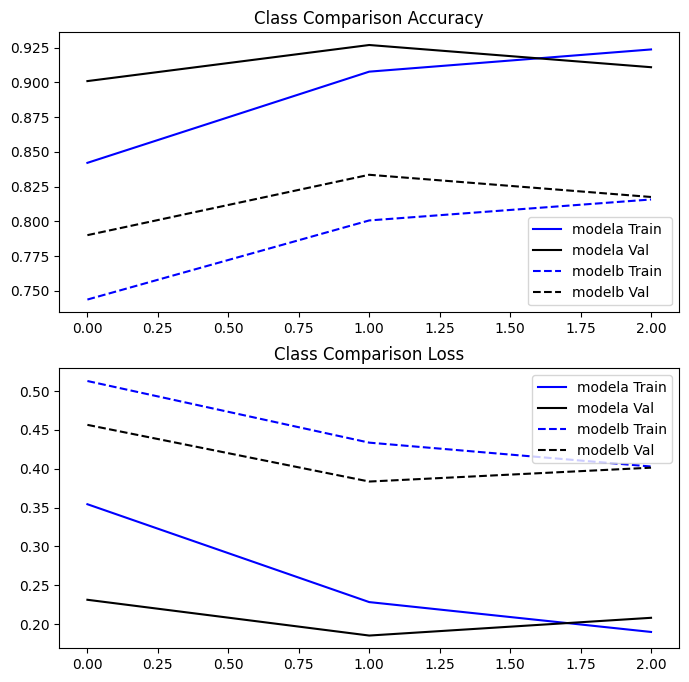

In [26]:
# Plot model training accuracy & loss vs training epoch
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, history_a.history['accuracy'], color='blue', label='modela Train')
plt.plot(epochs_range, history_a.history['val_accuracy'], color='black', label='modela Val')
plt.plot(epochs_range, history_b.history['accuracy'], color='blue', linestyle='dashed', label='modelb Train ')
plt.plot(epochs_range, history_b.history['val_accuracy'], color='black', linestyle='dashed', label='modelb Val')
plt.legend(loc='lower right')
plt.title('Class Comparison Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, history_a.history['loss'], color='blue', label='modela Train')
plt.plot(epochs_range, history_a.history['val_loss'], color='black', label='modela Val')
plt.plot(epochs_range, history_b.history['loss'], color='blue', linestyle='dashed', label='modelb Train')
plt.plot(epochs_range, history_b.history['val_loss'], color='black', linestyle='dashed', label='modelb Val')
plt.legend(loc='upper right')
plt.title('Class Comparison Loss')
plt.show()


## 5.2 Plot MIA results

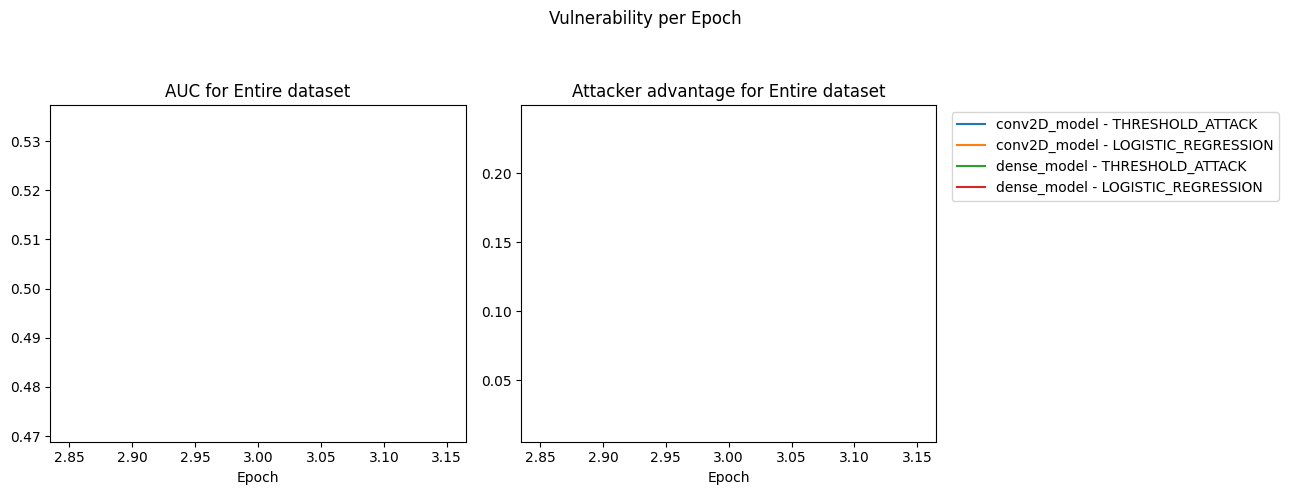

In [27]:
# Generate plots for experiment result visualization & demo sampling of the datasets
# Report MIA results for model experiments
privacy_metrics = (PrivacyMetric.AUC, PrivacyMetric.ATTACKER_ADVANTAGE)  # define report types for all experiments

# Plot MIA results
results = AttackResultsCollection(mia_reports)
epoch_plot = privacy_report.plot_by_epochs(
    results,
    privacy_metrics=privacy_metrics
)